In [61]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


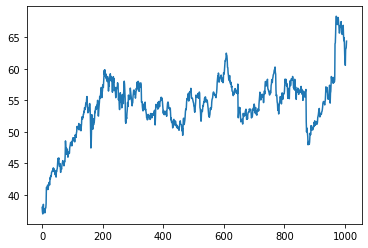

In [4]:
data = pd.read_csv('starbucks.csv')
data = data['Close']
data.plot()
plt.show()

In [12]:
train = data[:800]
validation = data[800:].reset_index(drop=True)

## dataset

In [9]:
class dataset(Dataset):
    def __init__(self, series, windowSize):
        self.X = []
        self.y = []
        for idx in range(0,len(series) - windowSize):
            self.X = np.append(self.X, series[idx:idx+windowSize])
            self.y = np.append(self.y, series[idx+windowSize])
        self.X = self.X.reshape(-1, windowSize)
        self.y = self.y.reshape(-1,1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.Tensor(self.X[idx])
        y = torch.Tensor(self.y[idx])
        return X, y

In [94]:
windowSize = 10
batchSize = 4

trainDataSet = dataset(train, windowSize=windowSize)
valDataSet = dataset(validation, windowSize=windowSize)

trainDataLoader = DataLoader(trainDataSet, batch_size=batchSize, shuffle=True, drop_last=True, num_workers=2)
valDataLoader = DataLoader(valDataSet, batch_size=batchSize, shuffle=True, drop_last=True, num_workers=2)

In [95]:
trainDataSet[0]

(tensor([38.0061, 37.2781, 36.9748, 37.8848, 38.4961, 37.2361, 37.4415, 37.7401,
         37.5301, 37.1381]),
 tensor([37.6188]))

In [96]:
dataiter = iter(trainDataLoader)
data = dataiter.next()

features, labels = data
print(features.shape, labels.shape)

torch.Size([4, 10]) torch.Size([4, 1])


## model

In [111]:
class model(nn.Module):
    def __init__(self, windowSize, batchSize):
        super().__init__()
        
        self.windowSize = windowSize
        self.batchSize = batchSize
        self.conv1d = nn.Conv1d(1, 8, kernel_size=2) 
        self.lstm = nn.LSTM(windowSize-2+1, 32, num_layers=2, batch_first=True)
        self.fcn1 = nn.Linear(32, 16)
        self.fcn2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1d(x) 
        # input : batch, inputDim, seqLen // ouput : batch, outChannel, outputDim
        out, _ = self.lstm(out) 
        # input : batch, seqLen, inputDim // ouput : (batch, seqLen, numOfDirection*hiddenSize) ,(h_n, c_n)
        out = self.fcn1(out[:, -1, :])
        out = self.relu(out)
        out = self.fcn2(out)
        return out

In [112]:
model = model(windowSize, batchSize).to(device)

In [113]:
model

model(
  (conv1d): Conv1d(1, 8, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(9, 32, num_layers=2, batch_first=True)
  (fcn1): Linear(in_features=32, out_features=16, bias=True)
  (fcn2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

## Train

In [114]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [115]:
numEpoch = 100
numIter = len(trainDataLoader)
print(numIter)

197


In [116]:
lossToViz = []

for i in tqdm_notebook(range(numEpoch)):
    for idx, (trainData, label) in enumerate(trainDataLoader):
        trainData = trainData.view(batchSize, 1, windowSize).to(device)
        label = label.to(device)
        
        yPred = model(trainData)
        loss = criterion(yPred, label)
        lossToViz.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (numEpoch+1) % 10 == 0: 
        print(f'epoch : {numEpoch+1} / {numEpochs},loss : {loss.item()}')        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


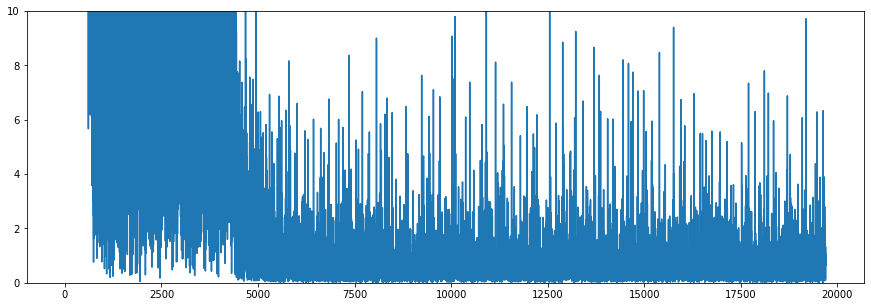

In [117]:
plt.figure(figsize=(15,5))
plt.ylim(0,10)
plt.plot(lossToViz)

In [118]:
trainForecast = []
with torch.no_grad():
    for idx, (trainData, label) in enumerate(trainDataLoader):
        trainData = trainData.view(batchSize, 1, windowSize).to(device)
        label = label.to(device)
            
        output = model(trainData).to('cpu')
        trainForecast = np.append(trainForecast, output)

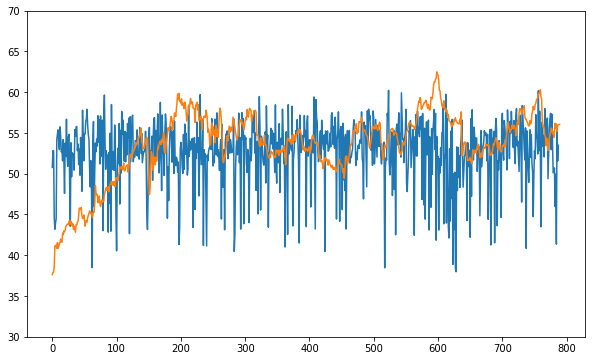

In [119]:
plt.figure(figsize=(10, 6))

plt.ylim(30,70)
plt.plot(trainForecast)
plt.plot(train[windowSize:].reset_index(drop=True))

What's wrong....